<h1> Research Project: Timing Variables </h1>

In [48]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from pandas.tseries.offsets import DateOffset

<h2> 1. Data </h2>
    
Data Sources: 

S&P500 Historical Constituents

In [40]:
path = r"C:\Users\tyyew\Desktop\Quant\Python\Data\components.csv"
index = pd.read_csv(path)

# create list of historical S&P500 constituents
index_set = set()
for row in index['tickers']:
    list_ = row.split(',')
    index_set.update(list_)
    
string = " ".join(index_set)
text_file = open(r"S&P500.txt", "w")
text_file.write(string)
text_file.close()

In [39]:
# create one-hot table


<h2> 2. Methodology </h2>

<h2> 3. Implementation </h2>

<h3> Timing Variables and Factor Returns </h3

In [292]:
path2 = r"C:\Users\tyyew\Desktop\Quant\Columbia MAFN\Study Materials\Sem 3\Quantitative Methods in Investment Management\Project\Timing Variables.xlsx"
timing_variables = pd.read_excel(path2,sheet_name = "Timing Variables", index_col = 0).fillna(0)
factor_returns = pd.read_excel(path2,sheet_name = "Factor Returns", index_col = 0, usecols = ['Date', 'Value', "Momentum"])

In [170]:
# whole period
start_date0 = pd.Timestamp('1989-12-31')
start_date = start_date0 + DateOffset(months=1)
end_date0 = pd.Timestamp('2022-01-31')
end_date = end_date0 + DateOffset(months=1)
# training period
train_start_date0 = pd.Timestamp('1989-12-31')
train_start_date = train_start_date0 + DateOffset(months=1)
train_end_date0 = pd.Timestamp('1999-12-31')
train_end_date = train_end_date0 + DateOffset(months=1)
# testing period
test_start_date0 = pd.Timestamp('2000-01-31')
test_start_date = test_start_date0 + DateOffset(months=1)
test_end_date0 = pd.Timestamp('2022-01-31')
test_end_date = test_end_date0 + DateOffset(months=1)

<function matplotlib.pyplot.show(close=None, block=None)>

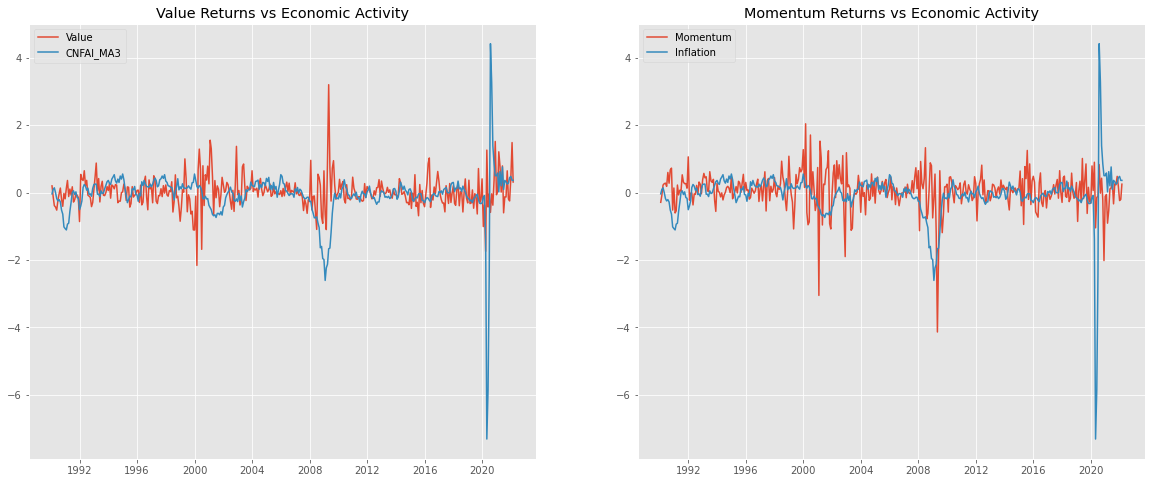

In [333]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))

ax1.plot(factor_returns.loc[start_date:end_date, 'Value'] * 12, label = 'Value')
ax1.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'], label = 'CNFAI_MA3')
ax1.set_title('Value Returns vs Economic Activity')
ax1.legend()

ax2.plot(factor_returns.loc[start_date:end_date, 'Momentum'] * 12, label = 'Momentum')
# ax21 = ax2.twinx()
ax2.plot(timing_variables.loc[start_date:end_date, 'CNFAI_MA3'],  label = 'Inflation')
ax2.set_title('Momentum Returns vs Economic Activity')
ax2.legend()

plt.show

In [265]:
def run_ols(predictor, factor, start_date, end_date):
    start_date1 = start_date + DateOffset(months=1)
    end_date1 = end_date + DateOffset(months=1)
    x = timing_variables.loc[start_date:end_date, predictor] 
    # x_norm = (x - x.mean())/x.std()
    X_train = np.array(x).reshape(-1,1)
    y_train = np.array(factor_returns.loc[start_date1:end_date1, factor])
    reg = LinearRegression().fit(X_train,y_train)
    
    r2 = reg.score(X_train,y_train)
    beta0 = reg.intercept_
    beta1 = reg.coef_
    
    
    return r2, beta0, beta1

In [379]:
def timing_table(factor, predictor, upper_bound = 1, lower_bound = 0):
    # model fit
    r2, beta0, beta1 = run_ols(predictor, factor , train_start_date0, train_end_date0)

    timing_df = pd.DataFrame(columns = ['Forecasted Returns', 'Actual Returns'])
    timing_df['Actual Returns'] = factor_returns.loc[test_start_date:test_end_date, factor]
    temp = timing_variables.loc[test_start_date0:test_end_date0, predictor] * beta1 + beta0
    timing_df['Forecasted Returns'] = temp.shift(1, freq  = 'infer')
    timing_df['Signal'] = timing_df['Forecasted Returns'].pct_change().fillna(0)
    timing_df['Gamma'] = 1/(1 + np.exp(-timing_df['Signal'])) # np.amin(upper_bound, np.amax(lower_bound, 1/(1 + np.exp(-timing_df['Signal']))))
    timing_df['Gamma'] = np.where(timing_df['Gamma'] > lower_bound, timing_df['Gamma'], lower_bound) # lower bound
    timing_df['Gamma'] = np.where(timing_df['Gamma'] <  upper_bound, timing_df['Gamma'], upper_bound) # upper bound
    return timing_df

mom_inflation = timing_table('Momentum', 'Inflation')
mom_GDP = timing_table('Momentum', 'CNFAI_MA3')
val_inflation = timing_table('Value', 'Inflation')
val_GDP = timing_table('Value', 'CNFAI_MA3')

<h3> Benchmark

In [380]:
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

In [393]:
factor_returns_test

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Date,,,,,,,,,
2000-02-29,-0.180291,0.170110,-0.005091,-0.040131,0.029949,-0.005091,-0.005091,-0.005091,-0.005091
2000-03-31,0.055698,-0.049388,0.003155,0.013663,-0.007354,0.001394,0.005718,0.012371,0.001804
2000-04-30,0.107482,-0.079772,0.013855,0.032580,-0.004870,0.009474,0.015262,0.031886,0.013150
2000-05-31,0.056688,-0.072787,-0.008049,0.004898,-0.020997,0.002123,-0.009654,-0.020997,-0.007257
2000-06-30,-0.140590,0.142343,0.000876,-0.027417,0.029170,0.012723,-0.001212,0.029170,0.001932
...,...,...,...,...,...,...,...,...,...
2021-10-31,-0.016103,0.040026,0.011962,0.006349,0.017575,0.012568,0.011417,0.009028,0.012246
2021-11-30,-0.020771,0.015547,-0.002612,-0.006244,0.001020,-0.000403,-0.002455,-0.006244,-0.002692
2021-12-31,0.036459,-0.019884,0.008288,0.013922,0.002653,0.009303,0.007011,0.005681,0.008947


In [381]:
# compute performance measures
ret_annualized = np.mean(factor_returns_test.loc[start_date:end_date]) * 12
vol_annualized = np.std(factor_returns_test.loc[start_date:end_date]) * 12
sharpe = np.mean(factor_returns_test.loc[start_date:end_date])/ np.std(factor_returns_test.loc[start_date:end_date])
# turnover = 
# drawdown = 
# transaction_cost = 
# information_ratio = 
summary = pd.DataFrame(columns = ['Return', 'Volatility', 'SharpeRatio'])
summary['Return'] = ret_annualized
summary['Volatility'] = vol_annualized
summary['SharpeRatio'] = sharpe
summary.T

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.038242,0.027217,0.032729,0.033832,0.031627,0.041001,0.034261,0.028208,0.037863
Volatility,0.511266,0.627434,0.213937,0.209312,0.265080,0.219066,0.228297,0.362646,0.213366
SharpeRatio,0.074799,0.043378,0.152986,0.161634,0.119311,0.187165,0.150070,0.077784,0.177456


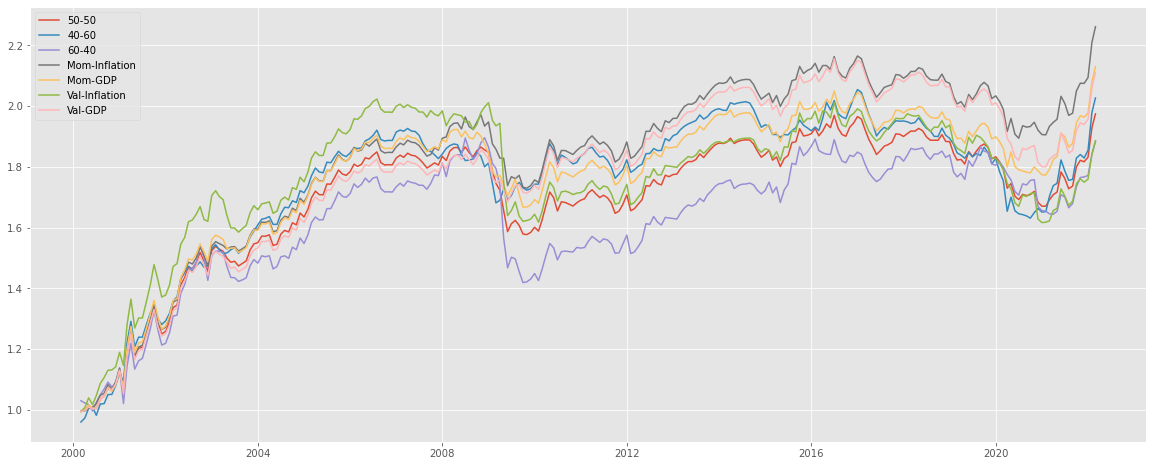

In [392]:
# cumulative returns
factor_cumret = np.cumprod(1 + factor_returns_test)

plt.figure(figsize = (20,8))
plt.plot(factor_cumret['ValMom-50-50'], label = '50-50')
plt.plot(factor_cumret['ValMom-60-40'], label = '40-60')
plt.plot(factor_cumret['ValMom-40-60'], label = '60-40')
plt.plot(factor_cumret['ValMom-gamma1'], label = 'Mom-Inflation')
plt.plot(factor_cumret['ValMom-gamma2'], label = 'Mom-GDP')
plt.plot(factor_cumret['ValMom-gamma3'], label = 'Val-Inflation')
plt.plot(factor_cumret['ValMom-gamma4'], label = 'Val-GDP')
plt.legend()

<h2> 4. Appendix

<h3> Gamma

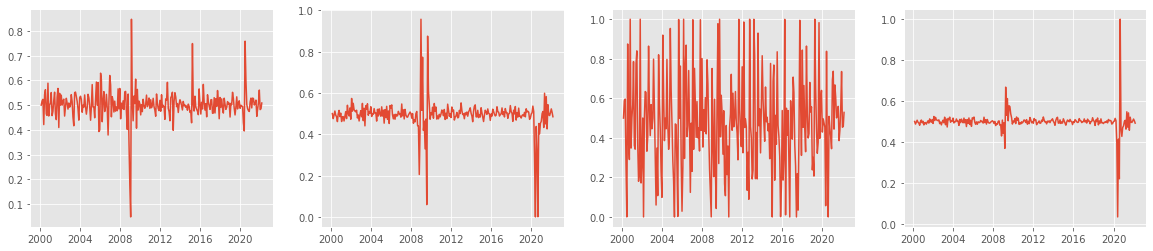

In [354]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,4))

ax1.plot(mom_inflation['Gamma'])
ax2.plot(mom_GDP['Gamma'])
ax3.plot(val_inflation['Gamma'])
ax4.plot(val_GDP['Gamma'])

<h3> Bounded Gamma </h3>

In [382]:
# 40-60 bound
mom_inflation = timing_table('Momentum', 'Inflation', 0.6, 0.4)
mom_GDP = timing_table('Momentum', 'CNFAI_MA3', 0.6, 0.4)
val_inflation = timing_table('Value', 'Inflation', 0.6, 0.4)
val_GDP = timing_table('Value', 'CNFAI_MA3', 0.6, 0.4)

In [386]:
factor_returns_test = factor_returns.loc[test_start_date:test_end_date].copy()
# naive benchmark
factor_returns_test['ValMom-50-50'] = 0.5 * (factor_returns_test['Value'] + factor_returns_test['Momentum'])
# static 60-40 
factor_returns_test['ValMom-60-40'] = 0.6 * factor_returns_test['Value'] + 0.4 * factor_returns_test['Momentum']
# static 40-60
factor_returns_test['ValMom-40-60'] = 0.4 * factor_returns_test['Value'] + 0.6 * factor_returns_test['Momentum']
# dynamic
factor_returns_test['ValMom-gamma1']  = factor_returns_test['Value'] * (1 - mom_inflation['Gamma']) + factor_returns_test['Momentum'] * (mom_inflation['Gamma'])
factor_returns_test['ValMom-gamma2']  = factor_returns_test['Value'] * (1 - mom_GDP['Gamma']) + factor_returns_test['Momentum'] * (mom_GDP['Gamma'])
factor_returns_test['ValMom-gamma3']  = factor_returns_test['Value'] * (val_inflation['Gamma']) + factor_returns_test['Momentum'] * (1 - val_inflation['Gamma'])
factor_returns_test['ValMom-gamma4']  = factor_returns_test['Value'] * (val_GDP['Gamma']) + factor_returns_test['Momentum'] * (1 - val_GDP['Gamma'])

In [387]:
# compute performance measures
ret_annualized = np.mean(factor_returns_test.loc[start_date:end_date]) * 12
vol_annualized = np.std(factor_returns_test.loc[start_date:end_date]) * 12
sharpe = np.mean(factor_returns_test.loc[start_date:end_date])/ np.std(factor_returns_test.loc[start_date:end_date])
# turnover = 
# drawdown = 
# transaction_cost = 
# information_ratio = 
summary = pd.DataFrame(columns = ['Return', 'Volatility', 'SharpeRatio'])
summary['Return'] = ret_annualized
summary['Volatility'] = vol_annualized
summary['SharpeRatio'] = sharpe
summary.T

,Value,Momentum,ValMom-50-50,ValMom-60-40,ValMom-40-60,ValMom-gamma1,ValMom-gamma2,ValMom-gamma3,ValMom-gamma4
Return,0.038242,0.027217,0.032729,0.033832,0.031627,0.038911,0.036104,0.031151,0.035709
Volatility,0.511266,0.627434,0.213937,0.209312,0.265080,0.215058,0.210584,0.239608,0.212170
SharpeRatio,0.074799,0.043378,0.152986,0.161634,0.119311,0.180931,0.171447,0.130009,0.168303


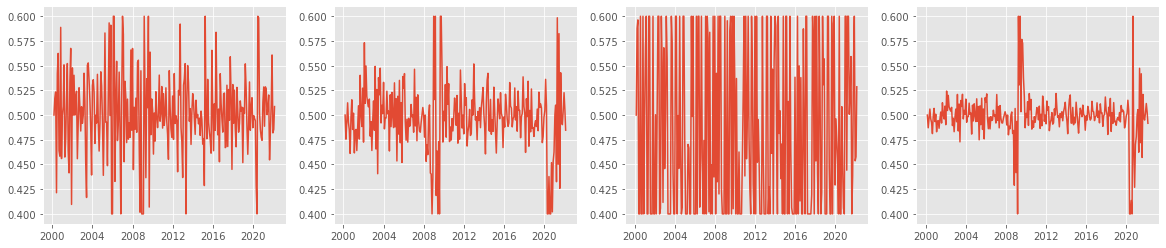

In [388]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (20,4))

ax1.plot(mom_inflation['Gamma'])
ax2.plot(mom_GDP['Gamma'])
ax3.plot(val_inflation['Gamma'])
ax4.plot(val_GDP['Gamma'])